In [92]:
import numpy as np
import pandas as pd
import os
import urllib
from PIL import Image 
import matplotlib.pyplot as plt
import cv2
import re
import shutil

## Part 1 - CSV

### Source 1 Data preparation from json

In [30]:
# reading file
df = pd.read_json('data/Indian_Number_plates.json', lines=True )
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [31]:
# creating folder for saving images
try:
    os.mkdir('data/Indian_Number_Plates')
except:
    pass

In [32]:
# downloading images and getting annotation form json

dataset = dict()
dataset["image_name"] = list()   # can use square bracket
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

counter = 0
for index, row in df.iterrows():
    #img = urllib.request.urlopen(row['content'])
    #img = Image.open(img)
    #img = img.convert('RGB')
    #img.save('data/Indian_Number_Plates/licenced_plates{}.jpg'.format(index), 'JPEG')
    
    dataset["image_name"].append('licenced_plates{}.jpg'.format(index))
    
    annot =  row['annotation'][0]
    
    dataset["image_width"].append(annot['imageWidth'])
    dataset["image_height"].append(annot['imageHeight'])
    
    dataset["top_x"].append(annot['points'][0]['x'])
    dataset["top_y"].append(annot['points'][0]['y'])
    dataset["bottom_x"].append(annot['points'][1]['x'])
    dataset["bottom_y"].append(annot['points'][1]['y'])
    
print("Total images downloaded {}.".format(index+1))

Total images downloaded 237.


In [33]:
# creating dataset
df_json = pd.DataFrame(dataset)

In [34]:
# checking min width and height of image for image data generator
print('min width {}'.format(df_json['image_width'].min()))
print('min height {}'.format(df_json['image_height'].min()))

min width 229
min height 139


#### Cross checking images

In [35]:
# function to view images
def img_num_plate_json(df, image_number):   
    
    plt.style.use('seaborn')
    
    # converitng image to array
    img1 = np.array(Image.open('data/Indian_Number_Plates/licenced_plates{}.jpg'.format(image_number)))
    
    #width & height
    width = df['image_width'][image_number]
    height = df['image_height'][image_number]
    
    #num plate dimentions
    tx = int(df["top_x"].iloc[image_number] * width)
    ty = int(df["top_y"].iloc[image_number] * height)
    bx = int(df["bottom_x"].iloc[image_number] * width)
    by = int(df["bottom_y"].iloc[image_number] * height)
    
    # rectangle on image
    img_rct = cv2.rectangle(img=img1, pt1=(tx, ty), pt2=(bx, by), color = (0, 255, 0), thickness=3)
    
    # plate
    plate = Image.fromarray(img1)
    plate1 = plate.crop(box=(tx,ty,bx,by))
    
    # plotting
    plt.imshow(img_rct)
    plt.title('Car Image')
    plt.show()
    
    plt.imshow(plate1)
    plt.title('Plate')
    plt.show()

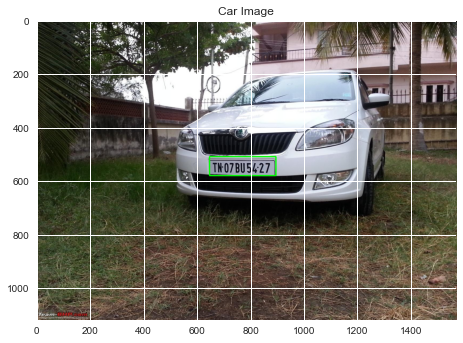

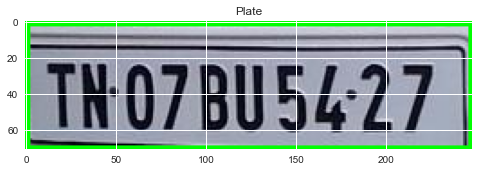

In [36]:
# cross checking images
img_num_plate_json(df_json, 8)

#### Saving to csv

In [37]:
# exporting it to csv for future referance
df_json.to_csv('data/json_indian_license_plates.csv', index=False)

In [38]:
# reading exported csv
df_json = pd.read_csv("data/json_indian_license_plates.csv")
df_json.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licenced_plates0.jpg,806,466,0.722084,0.587983,0.868486,0.688841
1,licenced_plates1.jpg,494,449,0.161943,0.850780,0.582996,1.000000
2,licenced_plates2.jpg,500,314,0.082000,0.697452,0.230000,0.828025
3,licenced_plates3.jpg,500,469,0.434000,0.667377,0.718000,0.765458
4,licenced_plates4.jpg,1001,563,0.208791,0.390764,0.865135,0.984014


### Source 2 Data preparation from xml

In [39]:
# extracting annotation information from xml

width_list = []
height_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for i in range(0, 433):
    with open('data/xml/annotations/Cars{}.xml'.format(i)) as f:
        for index,line in enumerate(f.readlines()):
            if index==5:
                width = int(re.sub( '[^\d*]','', line))
                width_list.append(width)
            elif index ==6:
                height = int(re.sub( '[^\d*]','', line))
                height_list.append(height)
            elif index==17:
                xmin = int(re.sub( '[^\d*]','', line))
                xmin_list.append(xmin)
            elif index==18:
                ymin = int(re.sub( '[^\d*]','', line))
                ymin_list.append(ymin)
            elif index==19:
                xmax = int(re.sub( '[^\d*]','', line))
                xmax_list.append(xmax)
            elif index==20:
                ymax = int(re.sub( '[^\d*]','', line))
                ymax_list.append(ymax)
            

In [40]:
# extracting image names

image_name = []
for i in range(0, 433):
    name = 'Cars{}.png'.format(i)
    image_name.append(name)

In [41]:
# convering xml data to dataframe

df_xml = pd.DataFrame({'image_name': image_name,
                       'image_width' : width_list,
                       'image_height': height_list,
                       'top_x': xmin_list,
                       'top_y': ymin_list,
                       'bottom_x': xmax_list,
                       'bottom_y' : ymax_list})

In [42]:
df_xml.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,Cars0.png,500,268,226,125,419,173
1,Cars1.png,400,248,134,128,262,160
2,Cars2.png,400,400,229,176,270,193
3,Cars3.png,400,225,142,128,261,157
4,Cars4.png,590,350,156,82,503,253


In [43]:
# checking min width and height of image for image data generator
print('min width {}'.format(df_xml['image_width'].min()))
print('min height {}'.format(df_xml['image_height'].min()))

min width 225
min height 141


In [44]:
# converting columns same as json data
df_xml["top_x"] = np.array(df_xml['top_x'])/ np.array(df_xml['image_width'])
df_xml["top_y"] = np.array(df_xml['top_y'])/ np.array(df_xml['image_height'])
df_xml["bottom_x"] = np.array(df_xml['bottom_x'])/ np.array(df_xml['image_width'])
df_xml["bottom_y"] = np.array(df_xml['bottom_y'])/ np.array(df_xml['image_height'])

#### Cross checking images

In [73]:
# formula for image view
def img_num_plate_xml(df, image_number):   
    
    plt.style.use('seaborn')
    
    # converitng image to array
    img1 = np.array(Image.open('data/xml/images/Cars{}.png'.format(image_number)))
    
    #width & height
    width = df['image_width'][image_number]
    height = df['image_height'][image_number]

    #num plate dimentions
    tx = int(df["top_x"].iloc[image_number]*width )
    ty = int(df["top_y"].iloc[image_number]*height )
    bx = int(df["bottom_x"].iloc[image_number]*width )
    by = int(df["bottom_y"].iloc[image_number]*height )
    
    # rectangle on image
    img_rct = cv2.rectangle(img=img1, pt1=(tx, ty), pt2=(bx, by), color = (0, 255, 0), thickness=3)
    
    # plate
    plate = Image.fromarray(img1)
    plate1 = plate.crop(box=(tx,ty,bx,by))
    
    # plotting
    plt.imshow(img_rct)
    plt.title('Car Image')
    plt.show()
    
    plt.imshow(plate1)
    plt.title('Plate')
    plt.show()    

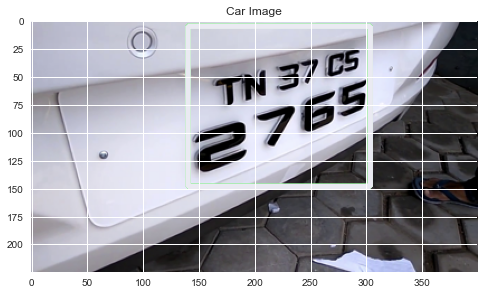

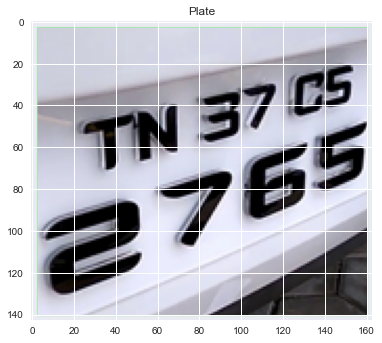

In [74]:
# cross checking image
img_num_plate_xml(df_xml, 10)

#### Saving to csv

In [47]:
df_xml.to_csv('data/xml_indian_license_plate.csv', index=False)

### Combining both json and xml

In [48]:
#reading json
df_json = pd.read_csv('data/json_indian_license_plates.csv')

In [145]:
# combining both data
df_combined = pd.concat([df_json, df_xml], axis=0)
df_combined.reset_index(inplace=True)
df_combined.rename({'index':'image_number'}, axis=1, inplace=True)  # adding image number to combined df
df_combined.head()

,image_number,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,0,licenced_plates0.jpg,806,466,0.722084,0.587983,0.868486,0.688841
1,1,licenced_plates1.jpg,494,449,0.161943,0.850780,0.582996,1.000000
2,2,licenced_plates2.jpg,500,314,0.082000,0.697452,0.230000,0.828025
3,3,licenced_plates3.jpg,500,469,0.434000,0.667377,0.718000,0.765458
4,4,licenced_plates4.jpg,1001,563,0.208791,0.390764,0.865135,0.984014


In [146]:
# saving to csv
df_combined.to_csv('data/combined.csv',index=False)

In [147]:
df_combined = pd.read_csv('data/combined.csv')
df_combined

,image_number,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,0,licenced_plates0.jpg,806,466,0.722084,0.587983,0.868486,0.688841
1,1,licenced_plates1.jpg,494,449,0.161943,0.850780,0.582996,1.000000
2,2,licenced_plates2.jpg,500,314,0.082000,0.697452,0.230000,0.828025
3,3,licenced_plates3.jpg,500,469,0.434000,0.667377,0.718000,0.765458
4,4,licenced_plates4.jpg,1001,563,0.208791,0.390764,0.865135,0.984014
...,...,...,...,...,...,...,...,...
665,428,Cars428.png,400,225,0.355000,0.568889,0.645000,0.697778
666,429,Cars429.png,301,400,0.285714,0.415000,0.691030,0.487500
667,430,Cars430.png,400,225,0.095000,0.706667,0.290000,0.875556
668,431,Cars431.png,400,192,0.137500,0.427083,0.857500,0.765625


## Part 2 - Image preparation

In [100]:
# creating folder for saving images
try:
    os.mkdir('data/training_car_images')
except:
    pass

In [112]:
# variables

json_image_path = 'data/Indian_Number_Plates/' 
xml_image_path = 'data/xml/images/' 

# getting list of path + filenames
json_filename = list(json_image_path+df_json['image_name'])
xml_filename = list(xml_image_path+df_xml['image_name'])

# combining json and xml lists
combined_filepath = json_filename + xml_filename

# destination to copy
destination_path = 'data/training_car_images/' 

In [114]:
# copying file to destination
for name in combined_filepath:
    shutil.copy(name, destination_path)

